In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

n_detectors = 6
number_of_features = n_detectors*4*8
input_data = []
with open('data/PD_three_rings_with_particle_mass_detector_2cm.dat', 'r') as inpf: 
    l = inpf.readline()
    print(l)
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        # for i in range(6):
            # for digit in s[i + 1]:
                # features.append(float(digit))
        for digit in s[1:]:
            features.append(float(digit))
        input_data.append([b, features])
    # print(len(input_data))
    
    np.random.shuffle(input_data)
    input_sorted = sorted(input_data, key=lambda x: (x[0]))
    # print(input_data)
    
    features = np.zeros((len(input_data), number_of_features))
    labels = np.zeros((len(input_data), 1))
    incr = 0
    for elem in input_data:
        labels[incr] = np.array(elem[0])
        features[incr] = np.array(elem[1])
        incr += 1
    
    # print(input_sorted[:5])
    # print(input_data[:5])
print(features.shape)

b(4x8) angles and r 

(22000, 192)


In [92]:
# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    for i in range(groups):   # define borders of segments
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=np.int)
    incr = 0
    for elem in labels:   # iterate over all (not sorted) labels and encode them
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


number_of_groups = 4


# labels_encoded_list = []
# maximum_b = np.max(labels)
# for label in labels:
#     labels_encoded_list.append(encode_equi_segment(label[0], maximum_b, number_of_groups))
# labels_encoded = np.array(labels_encoded_list)
# train_labels = torch.flatten(torch.tensor(labels_encoded[:size_of_training_set]))
# test_labels = torch.flatten(torch.tensor(labels_encoded[size_of_training_set:]))


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32)

print(labels[:10])
labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print(labels_encoded_equisized[:10])
train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))




print('Set shape: ' + str(features.shape))
print('Train features shape: ' + str(train_features.shape))
print('Train labels shape: ' + str(train_labels.shape))
print('Test features shape: ' + str(test_features.shape))
print('Test labels shape: ' + str(test_labels.shape))

[[12.101]
 [ 9.87 ]
 [ 9.957]
 [12.355]
 [ 8.361]
 [ 7.321]
 [ 6.46 ]
 [ 7.758]
 [ 5.054]
 [12.326]]
Length of segment: 5500
Encoded into intervals: [(0, 6.974), (6.974, 9.814), (9.814, 12.043), (12.043, 16.347)]
[[3]
 [2]
 [2]
 [3]
 [1]
 [1]
 [0]
 [1]
 [0]
 [3]]
Set shape: (22000, 192)
Train features shape: torch.Size([17600, 192])
Train labels shape: torch.Size([17600])
Test features shape: torch.Size([4400, 192])
Test labels shape: torch.Size([4400])


In [93]:
# Linear Fully connected network. 
# Convolutional - three blocks below

def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = n_detectors*32, out_features = 64)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = 64, out_features = 16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        # self.lin3 = nn.Linear(in_features = 16, out_features = 30)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features = 30, out_features = 20)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 20, out_features = 12)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 12, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = 16, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t

In [94]:
net = Network()
print(net.out.weight)
optimizer = optim.Adam(net.parameters(), lr=0.01)
number_of_epoches = 500
loss_weights = torch.tensor([1.,1.,1.,1.])


total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []
for epoch in range(number_of_epoches):
    predicted = net(train_features)
    loss = F.cross_entropy(predicted, train_labels, loss_weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_correct = get_correct_predictions(predicted, train_labels)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss.item(), total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(loss.item())
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Parameter containing:
tensor([[-0.0061,  0.0178,  0.0244, -0.0124,  0.0189,  0.0093, -0.0215,  0.0068,
         -0.0327,  0.0060, -0.0031,  0.0134,  0.0250,  0.0132,  0.0232,  0.0180],
        [-0.0047,  0.0056,  0.0083, -0.0247, -0.0237,  0.0072, -0.0068,  0.0113,
         -0.0075,  0.0163,  0.0054, -0.0095,  0.0060, -0.0026,  0.0048,  0.0237],
        [ 0.0191,  0.0070,  0.0022,  0.0104,  0.0017, -0.0257,  0.0098, -0.0158,
          0.0141, -0.0427, -0.0061, -0.0162,  0.0208, -0.0252,  0.0172,  0.0078],
        [-0.0185, -0.0062,  0.0188, -0.0209, -0.0023,  0.0256, -0.0094, -0.0112,
          0.0240, -0.0291, -0.0169,  0.0012, -0.0060, -0.0154,  0.0261,  0.0337]],
       requires_grad=True)
Epoch:    0 |---> loss is 1.3869059086, total correct predictions:  4369, its 24.824%
Epoch:    1 |---> loss is 1.3841309547, total correct predictions:  6774, its 38.489%
Epoch:    2 |---> loss is 1.3737404346, total correct predictions:  6460, its 36.705%
Epoch:    3 |---> loss is 1.3537939787, 

Epoch:   89 |---> loss is 0.9865375161, total correct predictions: 13474, its 76.557%
Epoch:   90 |---> loss is 0.9832586050, total correct predictions: 13549, its 76.983%
Epoch:   91 |---> loss is 0.9806222320, total correct predictions: 13607, its 77.312%
Epoch:   92 |---> loss is 0.9811814427, total correct predictions: 13574, its 77.125%
Epoch:   93 |---> loss is 0.9815229774, total correct predictions: 13578, its 77.148%
Epoch:   94 |---> loss is 0.9808742404, total correct predictions: 13556, its 77.023%
Epoch:   95 |---> loss is 0.9779558778, total correct predictions: 13654, its 77.580%
Epoch:   96 |---> loss is 0.9749325514, total correct predictions: 13710, its 77.898%
Epoch:   97 |---> loss is 0.9750358462, total correct predictions: 13687, its 77.767%
Epoch:   98 |---> loss is 0.9753980637, total correct predictions: 13701, its 77.847%
Epoch:   99 |---> loss is 0.9745661020, total correct predictions: 13709, its 77.892%
Epoch:  100 |---> loss is 0.9727473855, total correct 

Epoch:  185 |---> loss is 0.9293582439, total correct predictions: 14485, its 82.301%
Epoch:  186 |---> loss is 0.9290587902, total correct predictions: 14500, its 82.386%
Epoch:  187 |---> loss is 0.9284980893, total correct predictions: 14511, its 82.449%
Epoch:  188 |---> loss is 0.9280976653, total correct predictions: 14516, its 82.477%
Epoch:  189 |---> loss is 0.9278910756, total correct predictions: 14524, its 82.523%
Epoch:  190 |---> loss is 0.9272648096, total correct predictions: 14543, its 82.631%
Epoch:  191 |---> loss is 0.9272542596, total correct predictions: 14534, its 82.580%
Epoch:  192 |---> loss is 0.9264402986, total correct predictions: 14555, its 82.699%
Epoch:  193 |---> loss is 0.9264782071, total correct predictions: 14554, its 82.693%
Epoch:  194 |---> loss is 0.9258595109, total correct predictions: 14564, its 82.750%
Epoch:  195 |---> loss is 0.9257482290, total correct predictions: 14563, its 82.744%
Epoch:  196 |---> loss is 0.9252864122, total correct 

Epoch:  283 |---> loss is 0.9076095819, total correct predictions: 14818, its 84.193%
Epoch:  284 |---> loss is 0.9074850082, total correct predictions: 14819, its 84.199%
Epoch:  285 |---> loss is 0.9073621035, total correct predictions: 14817, its 84.188%
Epoch:  286 |---> loss is 0.9072377086, total correct predictions: 14820, its 84.205%
Epoch:  287 |---> loss is 0.9071139097, total correct predictions: 14820, its 84.205%
Epoch:  288 |---> loss is 0.9069908857, total correct predictions: 14823, its 84.222%
Epoch:  289 |---> loss is 0.9068674445, total correct predictions: 14825, its 84.233%
Epoch:  290 |---> loss is 0.9067466259, total correct predictions: 14826, its 84.239%
Epoch:  291 |---> loss is 0.9066262841, total correct predictions: 14828, its 84.250%
Epoch:  292 |---> loss is 0.9065156579, total correct predictions: 14828, its 84.250%
Epoch:  293 |---> loss is 0.9064016342, total correct predictions: 14829, its 84.256%
Epoch:  294 |---> loss is 0.9062873125, total correct 

Epoch:  379 |---> loss is 0.8984012008, total correct predictions: 14952, its 84.955%
Epoch:  380 |---> loss is 0.8983232975, total correct predictions: 14952, its 84.955%
Epoch:  381 |---> loss is 0.8981825113, total correct predictions: 14953, its 84.960%
Epoch:  382 |---> loss is 0.8980758786, total correct predictions: 14953, its 84.960%
Epoch:  383 |---> loss is 0.8980128765, total correct predictions: 14955, its 84.972%
Epoch:  384 |---> loss is 0.8978877664, total correct predictions: 14957, its 84.983%
Epoch:  385 |---> loss is 0.8978272080, total correct predictions: 14958, its 84.989%
Epoch:  386 |---> loss is 0.8976743817, total correct predictions: 14960, its 85.000%
Epoch:  387 |---> loss is 0.8976380229, total correct predictions: 14959, its 84.994%
Epoch:  388 |---> loss is 0.8975114822, total correct predictions: 14961, its 85.006%
Epoch:  389 |---> loss is 0.8974500299, total correct predictions: 14960, its 85.000%
Epoch:  390 |---> loss is 0.8973874450, total correct 

Epoch:  479 |---> loss is 0.8931688070, total correct predictions: 15011, its 85.290%
Epoch:  480 |---> loss is 0.8931193352, total correct predictions: 15011, its 85.290%
Epoch:  481 |---> loss is 0.8930873275, total correct predictions: 15011, its 85.290%
Epoch:  482 |---> loss is 0.8930432796, total correct predictions: 15011, its 85.290%
Epoch:  483 |---> loss is 0.8929858804, total correct predictions: 15013, its 85.301%
Epoch:  484 |---> loss is 0.8929477334, total correct predictions: 15012, its 85.295%
Epoch:  485 |---> loss is 0.8929102421, total correct predictions: 15011, its 85.290%
Epoch:  486 |---> loss is 0.8928772211, total correct predictions: 15012, its 85.295%
Epoch:  487 |---> loss is 0.8928490877, total correct predictions: 15012, its 85.295%
Epoch:  488 |---> loss is 0.8928067088, total correct predictions: 15013, its 85.301%
Epoch:  489 |---> loss is 0.8927409649, total correct predictions: 15013, its 85.301%
Epoch:  490 |---> loss is 0.8927107453, total correct 

Test accuracy is 70.05%


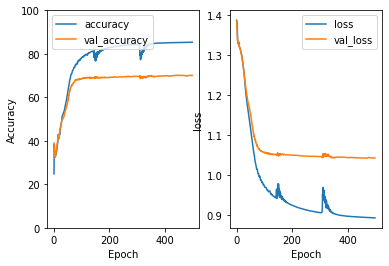

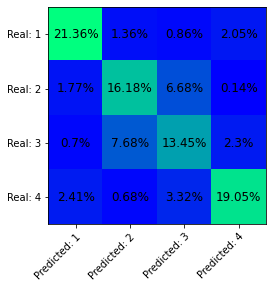

In [95]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions * 100 /test_features.shape[0]))
    
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      # horizontal axis - predicted, vertical - true
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%', ha="center", va="center", size=12)


[[12.101]
 [ 9.87 ]
 [ 9.957]]
[[3]
 [2]
 [2]]
tensor([[0.0000, 0.9383, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


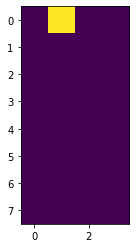

In [96]:
# Convolutional NN
features_reshaped = np.reshape(features, (features.shape[0], n_detectors, 8, 4))

train_features_c = torch.tensor(features_reshaped[:size_of_training_set], dtype=torch.float32)
test_features_c = torch.tensor(features_reshaped[size_of_training_set:], dtype=torch.float32)


print(labels[:3])
print(labels_encoded_equisized[:3])

# Equisized
train_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))

# print(train_features_conv.shape)
print(train_features_c[0][0])
plt.imshow(train_features_c[0][0])
plt.show()
# print(train_features_c[0][1])
# plt.imshow(train_features_c[0][1])
# plt.show()

In [97]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(4, 2))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        # print(self.conv1.weight)
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        
        self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=60, out_features=16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        # self.lin3 = nn.Linear(in_features=30, out_features=12)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=30, out_features=16)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=16, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = t
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, n_detectors*2*5*3)))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t

In [98]:
net_c = NetworkConv()
print(net_c.conv1.weight)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.01, weight_decay=0.0001)
number_of_epoches_c = 500
# Here define weights for loss contribution of segments
loss_weights_c = torch.tensor([1.,1.,1.,1.])

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []
for epoch in range(number_of_epoches_c):
    predicted_c = net_c(train_features_c)
    loss_c = F.cross_entropy(predicted_c, train_labels_c, loss_weights_c)
    optimizer_c.zero_grad()
    loss_c.backward()
    optimizer_c.step()
    
    total_correct_c = get_correct_predictions(predicted_c, train_labels_c)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss_c.item(), total_correct_c, total_correct_c*100/train_features_c.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(loss_c.item())
        total_accuracy_c.append(total_correct_c*100/train_features_c.shape[0])
        
        test_preds_c = net_c(test_features_c)
        total_val_loss_c.append(F.cross_entropy(test_preds_c, test_labels_c, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds_c, test_labels_c)*100/test_features_c.shape[0])

Parameter containing:
tensor([[[[ 7.8461e-03,  3.8986e-03],
          [-4.6233e-02,  6.0765e-03],
          [ 2.8536e-02,  1.4415e-02],
          [-7.9404e-03, -2.6155e-02]],

         [[-1.8617e-03,  2.0640e-02],
          [ 2.1612e-02, -1.4703e-02],
          [ 1.8040e-02, -2.7844e-03],
          [-6.3668e-03, -2.4219e-02]],

         [[ 3.6082e-02,  2.6352e-03],
          [ 8.5889e-05,  2.2664e-02],
          [-4.5465e-02,  1.8752e-02],
          [-3.3384e-02,  1.3816e-03]],

         [[-4.8029e-03, -3.2852e-03],
          [ 2.6501e-02, -8.4624e-03],
          [ 3.7916e-02, -1.8340e-02],
          [ 3.6310e-03,  2.0921e-04]],

         [[-2.5808e-02, -3.9339e-03],
          [-1.3734e-02,  9.1683e-03],
          [-4.2627e-03,  1.1962e-02],
          [-6.5031e-03, -6.9175e-03]],

         [[-3.6908e-02, -1.3742e-03],
          [-1.1168e-02,  2.4347e-02],
          [ 5.5220e-03, -2.1128e-02],
          [ 8.9454e-03,  9.0229e-03]]],


        [[[ 1.4731e-02,  8.9084e-03],
          [ 3.

Epoch:    1 |---> loss is 1.3868596554, total correct predictions:  4412, its 25.068%
Epoch:    2 |---> loss is 1.3862117529, total correct predictions:  4680, its 26.591%
Epoch:    3 |---> loss is 1.3832058907, total correct predictions:  4332, its 24.614%
Epoch:    4 |---> loss is 1.3741908073, total correct predictions:  4407, its 25.040%
Epoch:    5 |---> loss is 1.3564027548, total correct predictions:  4425, its 25.142%
Epoch:    6 |---> loss is 1.3432631493, total correct predictions:  4425, its 25.142%
Epoch:    7 |---> loss is 1.3412853479, total correct predictions:  4592, its 26.091%
Epoch:    8 |---> loss is 1.3268882036, total correct predictions:  5018, its 28.511%
Epoch:    9 |---> loss is 1.3273115158, total correct predictions:  5735, its 32.585%
Epoch:   10 |---> loss is 1.3243882656, total correct predictions:  6685, its 37.983%
Epoch:   11 |---> loss is 1.3219969273, total correct predictions:  7638, its 43.398%
Epoch:   12 |---> loss is 1.3200868368, total correct 

Epoch:   97 |---> loss is 1.0436390638, total correct predictions: 12250, its 69.602%
Epoch:   98 |---> loss is 1.0448920727, total correct predictions: 12209, its 69.369%
Epoch:   99 |---> loss is 1.0427079201, total correct predictions: 12222, its 69.443%
Epoch:  100 |---> loss is 1.0377060175, total correct predictions: 12376, its 70.318%
Epoch:  101 |---> loss is 1.0393861532, total correct predictions: 12320, its 70.000%
Epoch:  102 |---> loss is 1.0412526131, total correct predictions: 12228, its 69.477%
Epoch:  103 |---> loss is 1.0385439396, total correct predictions: 12335, its 70.085%
Epoch:  104 |---> loss is 1.0373439789, total correct predictions: 12391, its 70.403%
Epoch:  105 |---> loss is 1.0334835052, total correct predictions: 12464, its 70.818%
Epoch:  106 |---> loss is 1.0324604511, total correct predictions: 12492, its 70.977%
Epoch:  107 |---> loss is 1.0338239670, total correct predictions: 12459, its 70.790%
Epoch:  108 |---> loss is 1.0324863195, total correct 

Epoch:  193 |---> loss is 0.9987514615, total correct predictions: 13113, its 74.506%
Epoch:  194 |---> loss is 0.9995818734, total correct predictions: 13069, its 74.256%
Epoch:  195 |---> loss is 0.9951430559, total correct predictions: 13175, its 74.858%
Epoch:  196 |---> loss is 0.9923304319, total correct predictions: 13253, its 75.301%
Epoch:  197 |---> loss is 0.9923948050, total correct predictions: 13255, its 75.312%
Epoch:  198 |---> loss is 0.9947875142, total correct predictions: 13179, its 74.881%
Epoch:  199 |---> loss is 0.9966391921, total correct predictions: 13152, its 74.727%
Epoch:  200 |---> loss is 0.9935548902, total correct predictions: 13205, its 75.028%
Epoch:  201 |---> loss is 0.9915444255, total correct predictions: 13285, its 75.483%
Epoch:  202 |---> loss is 0.9917535782, total correct predictions: 13282, its 75.466%
Epoch:  203 |---> loss is 0.9910877347, total correct predictions: 13283, its 75.472%
Epoch:  204 |---> loss is 0.9910619855, total correct 

Epoch:  289 |---> loss is 0.9786581397, total correct predictions: 13479, its 76.585%
Epoch:  290 |---> loss is 0.9860547781, total correct predictions: 13326, its 75.716%
Epoch:  291 |---> loss is 0.9861564636, total correct predictions: 13319, its 75.676%
Epoch:  292 |---> loss is 0.9898091555, total correct predictions: 13253, its 75.301%
Epoch:  293 |---> loss is 0.9810467958, total correct predictions: 13415, its 76.222%
Epoch:  294 |---> loss is 0.9910113811, total correct predictions: 13189, its 74.938%
Epoch:  295 |---> loss is 0.9844812155, total correct predictions: 13339, its 75.790%
Epoch:  296 |---> loss is 0.9869250655, total correct predictions: 13302, its 75.580%
Epoch:  297 |---> loss is 0.9851841331, total correct predictions: 13342, its 75.807%
Epoch:  298 |---> loss is 0.9826573730, total correct predictions: 13409, its 76.188%
Epoch:  299 |---> loss is 0.9853157997, total correct predictions: 13351, its 75.858%
Epoch:  300 |---> loss is 0.9816029072, total correct 

Epoch:  385 |---> loss is 0.9691021442, total correct predictions: 13669, its 77.665%
Epoch:  386 |---> loss is 0.9750463963, total correct predictions: 13494, its 76.670%
Epoch:  387 |---> loss is 0.9631558657, total correct predictions: 13800, its 78.409%
Epoch:  388 |---> loss is 0.9644255042, total correct predictions: 13782, its 78.307%
Epoch:  389 |---> loss is 0.9716594815, total correct predictions: 13608, its 77.318%
Epoch:  390 |---> loss is 0.9638397694, total correct predictions: 13787, its 78.335%
Epoch:  391 |---> loss is 0.9609876871, total correct predictions: 13845, its 78.665%
Epoch:  392 |---> loss is 0.9622197747, total correct predictions: 13820, its 78.523%
Epoch:  393 |---> loss is 0.9668288231, total correct predictions: 13727, its 77.994%
Epoch:  394 |---> loss is 0.9739421010, total correct predictions: 13560, its 77.045%
Epoch:  395 |---> loss is 0.9612005353, total correct predictions: 13855, its 78.722%
Epoch:  396 |---> loss is 0.9629253745, total correct 

Epoch:  481 |---> loss is 0.9599428773, total correct predictions: 13827, its 78.562%
Epoch:  482 |---> loss is 0.9633864760, total correct predictions: 13731, its 78.017%
Epoch:  483 |---> loss is 0.9605883956, total correct predictions: 13786, its 78.330%
Epoch:  484 |---> loss is 0.9624562860, total correct predictions: 13768, its 78.227%
Epoch:  485 |---> loss is 0.9575111866, total correct predictions: 13872, its 78.818%
Epoch:  486 |---> loss is 0.9610455036, total correct predictions: 13814, its 78.489%
Epoch:  487 |---> loss is 0.9572727084, total correct predictions: 13887, its 78.903%
Epoch:  488 |---> loss is 0.9590737224, total correct predictions: 13854, its 78.716%
Epoch:  489 |---> loss is 0.9559683800, total correct predictions: 13917, its 79.074%
Epoch:  490 |---> loss is 0.9581326842, total correct predictions: 13874, its 78.830%
Epoch:  491 |---> loss is 0.9568926692, total correct predictions: 13904, its 79.000%
Epoch:  492 |---> loss is 0.9594296813, total correct 

Test accuracy is 72.11%


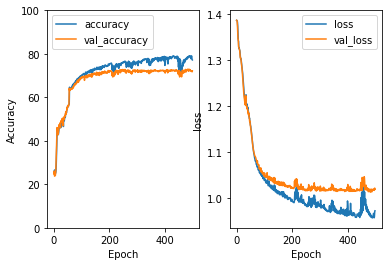

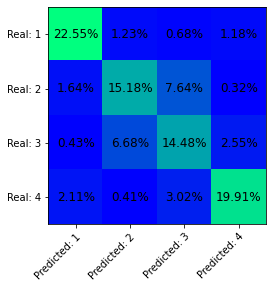

In [99]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features_c)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels_c)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions_c * 100 /test_features_c.shape[0]))
    
    stacked_c = torch.stack((test_labels_c, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features_c.shape[0],2)) + '%', ha="center", va="center", size=12)

In [100]:
p1 = net_c.lin1.weight.clone().detach()
print(p1.shape)
u, s1, v = torch.svd(p1)
print(s1)
p2 = net_c.lin2.weight.clone().detach()
print(p2.shape)
u, s2, v = torch.svd(p2)
print(s2)

torch.Size([60, 180])
tensor([7.4342e+00, 6.2331e+00, 4.0876e+00, 3.1343e+00, 2.7192e+00, 2.4516e+00,
        2.1997e+00, 1.6089e+00, 1.3795e+00, 1.3157e+00, 1.0906e+00, 9.8127e-01,
        9.5411e-01, 8.2721e-01, 7.9649e-01, 6.7818e-01, 5.8512e-01, 5.5070e-01,
        5.1281e-01, 4.8694e-01, 4.6225e-01, 3.9101e-01, 3.6803e-01, 3.1798e-01,
        2.8323e-01, 2.5914e-01, 2.5353e-01, 2.4454e-01, 2.1151e-01, 2.0595e-01,
        1.9792e-01, 1.9540e-01, 1.7622e-01, 1.7037e-01, 1.4706e-01, 1.3741e-01,
        1.3165e-01, 1.2399e-01, 1.1729e-01, 1.0967e-01, 9.9128e-02, 9.6511e-02,
        8.5839e-02, 7.3576e-02, 7.1755e-02, 6.7199e-02, 6.0581e-02, 5.7307e-02,
        5.1637e-02, 4.9035e-02, 4.6145e-02, 4.0681e-02, 3.8259e-02, 3.7442e-02,
        3.5467e-02, 3.2039e-02, 2.5062e-02, 2.2122e-02, 3.7379e-03, 1.1044e-03])
torch.Size([16, 60])
tensor([5.0795e+00, 2.8059e+00, 1.5708e+00, 1.1679e+00, 9.5050e-01, 7.5370e-01,
        3.5906e-01, 1.8720e-01, 1.7324e-01, 1.0562e-01, 7.7764e-02, 7.0391e-